# 1. 数据集1

## 1.1 数据集1整体处理

### 1.1.1 缺失值与异常值
删除所有缺失值，将较小值进行合并处理

In [1]:
import os
import copy

import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random
from itertools import cycle

from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import scale

import warnings 

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None) #显示所有列
pd.set_option('display.max_rows', None) #显示所有行

In [2]:
#1.读取数据
userinfo = pd.read_csv('TeleComm_User_Info.txt', encoding = 'gb18030')

#2.根据题目要求只考虑公众客户
target_data = userinfo[userinfo['客户类型']=='公众客户']  #根据题目要求找到公众客户对象
target_data = target_data.drop('客户类型',axis=1)  #从筛选过后的表删去客户类型属性列

#3.删除所有缺失值
target_data=target_data.dropna()

#4.较小数据处理
## 用户ID：无信息含量，因此删除
target_data = target_data.drop(['用户ID'],axis=1)

##性别：删去无法区分
target_data = target_data.drop((target_data[target_data['性别']=='无法区分']).index,axis=0)

##终端品牌：将人数1-5归为稀有品牌 人数6-10归为小众品牌，其余保持不变
group_brand=target_data.groupby(['终端品牌']).size()

group_brand1=group_brand[group_brand<=5]
list_brand1=group_brand1.index.tolist()
target_data.loc[target_data['终端品牌'].str.contains('|'.join(list_brand1)),'终端品牌'] = '稀有品牌'

group_brand2=group_brand[group_brand>5]
list_brand2=group_brand2[group_brand2<=10].index.tolist()
target_data.loc[target_data['终端品牌'].str.contains('|'.join(list_brand2)),'终端品牌'] = '小众品牌'

##终端类型：去掉0
target_data = target_data.drop((target_data[target_data['终端类型']=='0']).index,axis=0)

##总收入 去掉小于0
target_data = target_data.drop((target_data[target_data['总收入']<0]).index,axis=0)

##最近使用操作系统偏好：只考虑Android,IOS
target_data.loc[target_data['最近使用操作系统偏好'].str.contains("IOS"),'最近使用操作系统偏好'] = 'IOS'
target_data.loc[target_data['最近使用操作系统偏好'].str.contains("ANDROID"),'最近使用操作系统偏好'] = 'ANDROID'
target_data.loc[target_data['最近使用操作系统偏好'].str.contains("WINDOWS"),'最近使用操作系统偏好'] = 'Others'
target_data.loc[target_data['最近使用操作系统偏好'].str.contains("BLACKBERRY"),'最近使用操作系统偏好'] = 'Others'
target_data=target_data.drop((target_data[target_data['最近使用操作系统偏好']=="Others"]).index,axis=0)

##入网渠道类型：由于入网渠道和渠道类型描述的描述对象相同，因此只保留渠道类型描述
target_data = target_data.drop(['入网渠道类型'],axis=1)

##渠道类型描述：不考虑其他渠道
target_data = target_data.drop((target_data[target_data['渠道类型描述']=='其他渠道']).index,axis=0)

## 产品分类：将人数1-5归为稀有套餐 人数6-10归为小众套餐，其余保持不变
group_package=target_data.groupby(['产品分类']).size()

group_package1=group_package[group_package<=5]
list_package1=group_package1.index.tolist()
target_data.loc[target_data['产品分类'].str.contains('|'.join(list_package1)),'产品分类'] = '稀有套餐'

group_package2=group_package[group_package>5]
list_package2=group_package2[group_package2<=10].index.tolist()
target_data.loc[target_data['产品分类'].str.contains('|'.join(list_package2)),'产品分类'] = '小众套餐'

display(target_data.head())

,性别,年龄,归属地,在网时长,换机频率,终端品牌,终端类型,最近使用操作系统偏好,渠道类型描述,上网流量使用,漫游流量使用,总收入,增值收入,流量收入,短信收入,彩信收入,语音收入,是否欠费,产品大类,产品分类
0,女,20.0,石家庄,15,频繁换机型,LG,4G,ANDROID,社会渠道,568.399661,0.000000,76.25,45.90,35.7,1.20,1.2,4.35,否,本地套餐,4G本地套餐-26元套餐
1,女,63.0,北京,70,频繁换机型,苹果,3G,IOS,社会渠道,106.718701,6.202381,73.77,1.56,15.0,1.56,0.0,0.96,否,智慧沃家共享,智慧沃家共享套餐-全国流量包49.9元1GB
2,男,21.0,北京,33,频繁换机型,三星,4G,ANDROID,社会渠道,3930.230795,2.016909,164.60,15.00,1.6,15.00,0.0,23.60,是,国内流量套餐,150元4GB国内流量套餐
5,男,20.0,天津,45,频繁换机型,苹果,4G,IOS,社会渠道,2026.990448,1938.247254,227.30,104.84,120.0,3.00,0.0,18.15,否,基本套餐,106元基本套餐（含国内语音300分钟，国内流量800MB）
6,男,23.0,北京,45,频繁换机型,摩托罗拉,4G,ANDROID,社会渠道,5732.901909,1082.158408,144.00,75.00,60.0,15.00,0.0,9.00,否,校园专属-沃派,4G校园套餐-沃派60元套餐


In [3]:
#数据属性分类
nominal = ['性别', '归属地', '换机频率', '终端品牌', '终端类型', '最近使用操作系统偏好', 
           '渠道类型描述', '是否欠费', '产品大类', '产品分类']
interval =['年龄','在网时长','上网流量使用','漫游流量使用',
           '总收入','增值收入','流量收入','短信收入','彩信收入','语音收入']

variable = nominal + interval

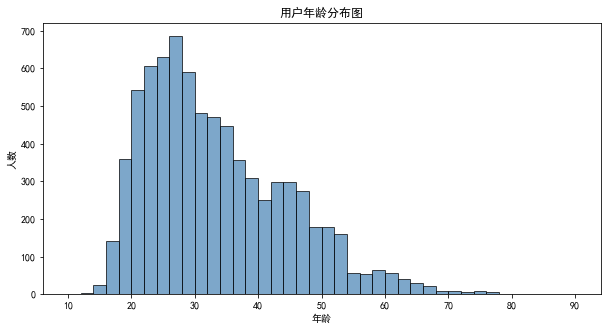

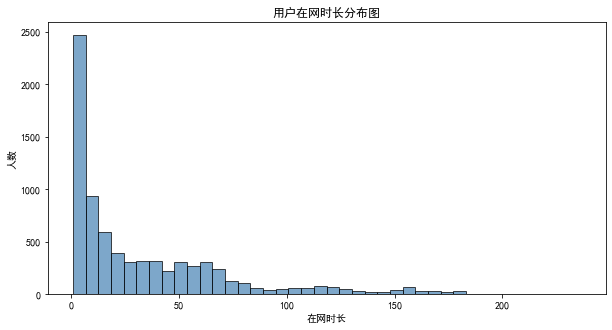

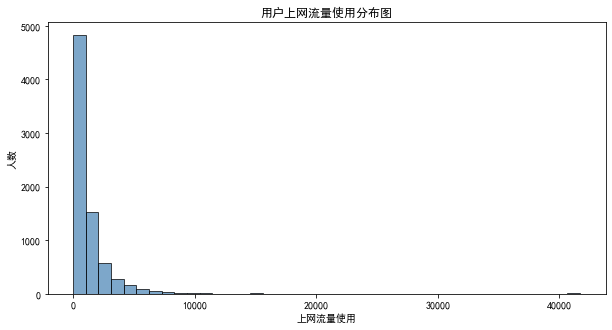

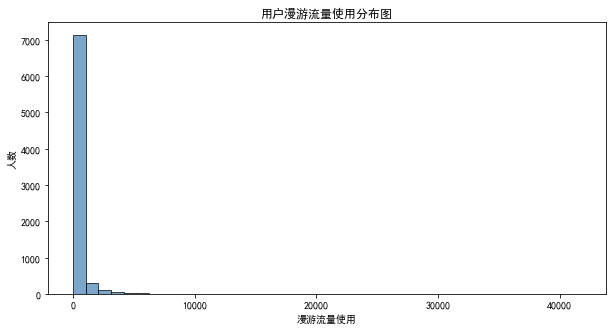

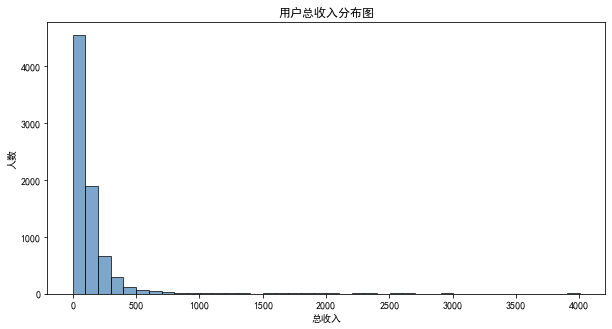

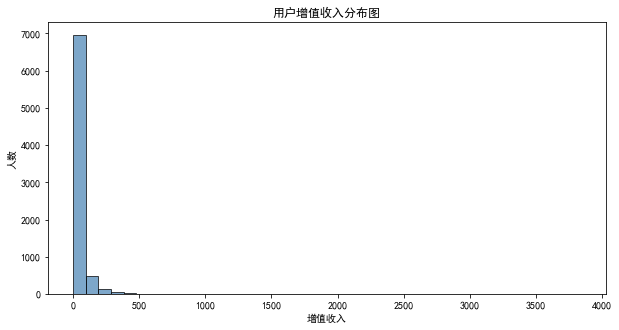

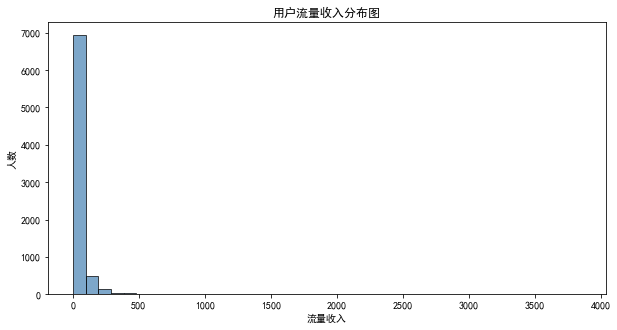

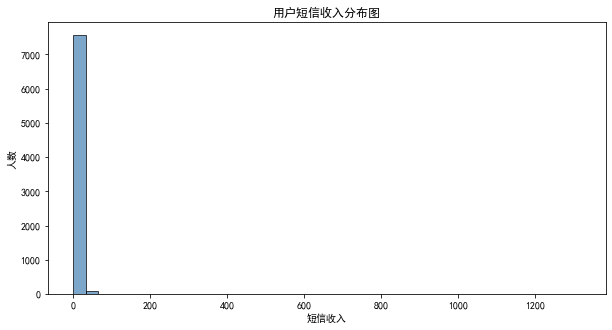

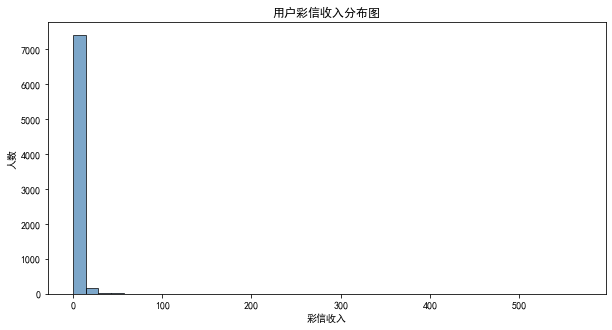

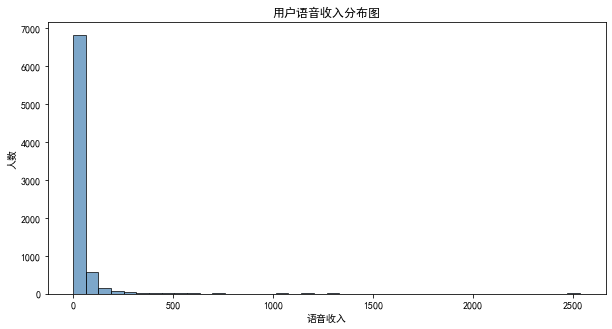

In [4]:
#查看各连续变量的分布: 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

for figure in interval:
    plt.figure(figsize=(10,5))
    plt.hist(target_data[figure], bins=40, facecolor="steelblue", edgecolor="black", alpha=0.7)
    plt.xlabel(figure)
    plt.ylabel("人数") 
    plt.title("用户"+figure+"分布图")
    plt.show()

In [5]:
#将数值变量取log
for column in interval:
    target_data[column] = (target_data[column]+1).apply(math.log)

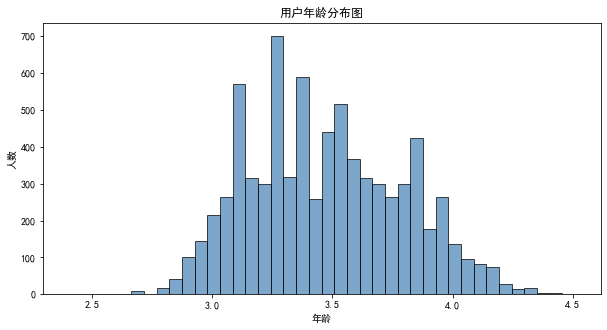

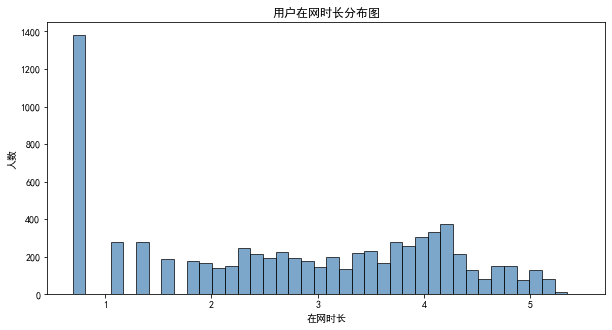

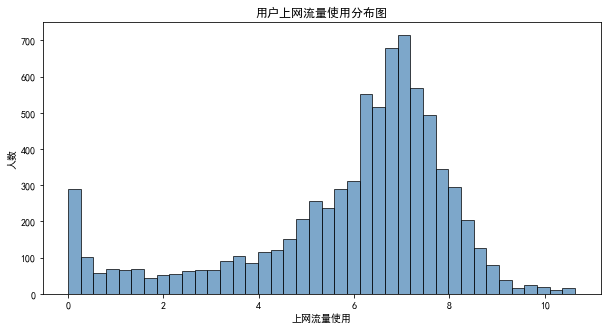

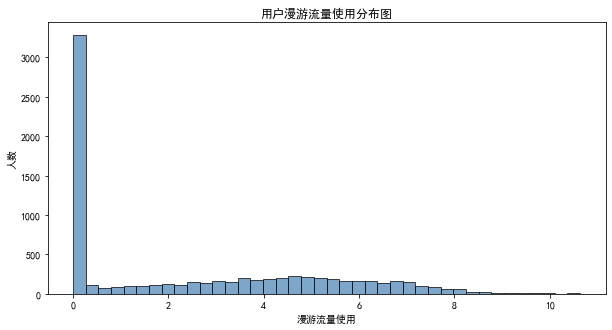

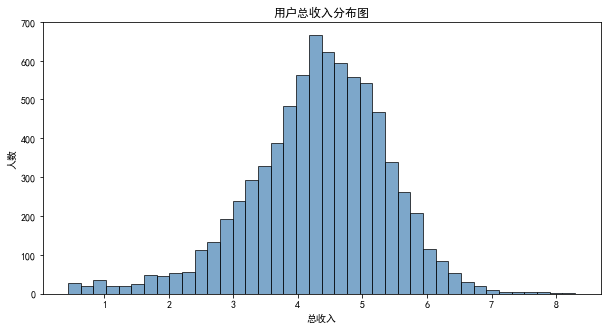

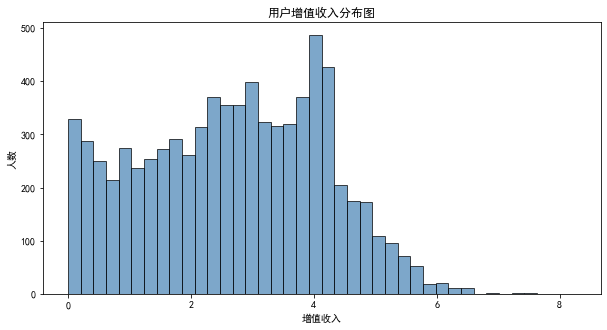

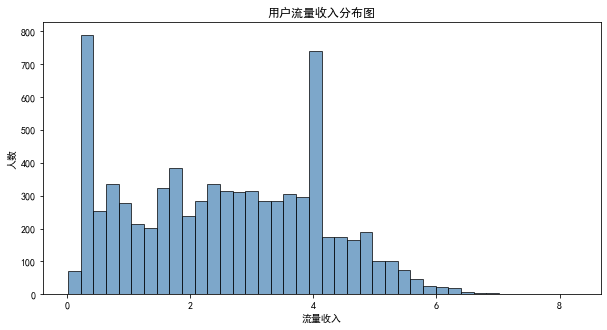

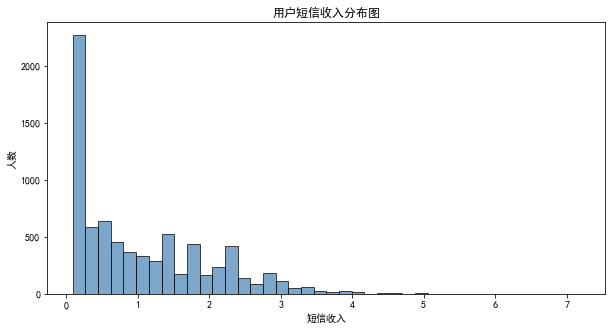

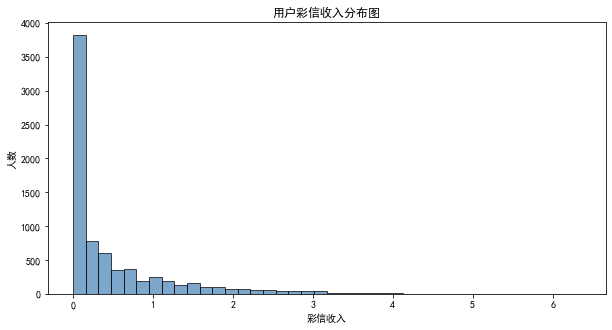

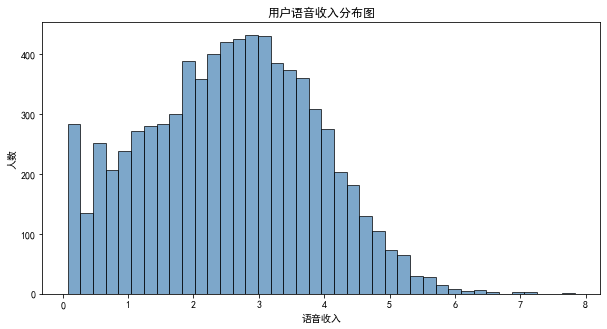

In [6]:
#查看各连续变量的分布: 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

for figure in interval:
    plt.figure(figsize=(10,5))
    plt.hist(target_data[figure], bins=40, facecolor="steelblue", edgecolor="black", alpha=0.7)
    plt.xlabel(figure)
    plt.ylabel("人数") 
    plt.title("用户"+figure+"分布图")
    plt.show()

### 1.1.2 数据因子化标准化处理
分类数据因子化处理，数值型数据标准化处理

In [11]:
dis_X = target_data[nominal]
con_X = target_data[interval]

###将所有分类数据因子化
dis_columns = dis_X.columns
for column in dis_columns:
    dis_X[column] = pd.factorize(dis_X[column])[0]
dis_X.index=range(len(dis_X))

###将所有数值数据映射到0，1之间
con_X_scale = scale(X=con_X,with_mean=True,with_std=True,copy=True)
con_X_scale = pd.DataFrame(con_X_scale, columns=con_X.columns)

data = pd.concat([dis_X,con_X_scale],axis=1)
data.head()

,性别,归属地,换机频率,终端品牌,终端类型,最近使用操作系统偏好,渠道类型描述,是否欠费,产品大类,产品分类,年龄,在网时长,上网流量使用,漫游流量使用,总收入,增值收入,流量收入,短信收入,彩信收入,语音收入
0,0,0,0,0,0,0,0,0,0,0,-1.341319,0.018429,0.199311,-0.938936,0.021621,0.782328,0.673687,-0.297717,0.319548,-0.690483
1,0,1,0,1,1,1,0,0,1,1,2.136567,1.095509,-0.551240,-0.206459,-0.009015,-1.169748,0.136026,-0.140833,-0.644616,-1.468032
2,1,1,0,2,0,0,0,1,2,2,-1.196131,0.563277,1.070247,-0.529282,0.737554,0.060419,-1.040781,1.756250,-0.644616,0.490881
3,1,2,0,1,0,1,0,0,3,3,-1.341319,0.781774,0.771882,1.869442,1.039019,1.328687,1.446327,0.321162,-0.644616,0.296953
4,1,1,0,3,0,0,0,0,4,4,-0.924571,0.781774,1.240385,1.653373,0.612830,1.106364,1.002750,1.756250,-0.644616,-0.206145


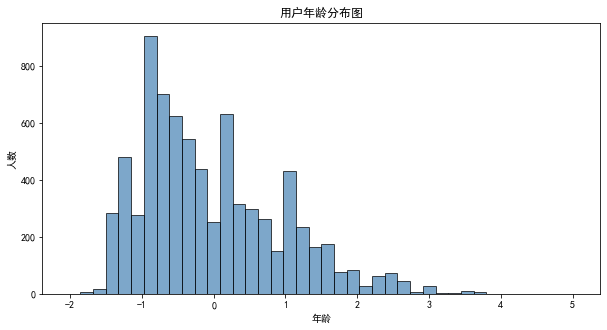

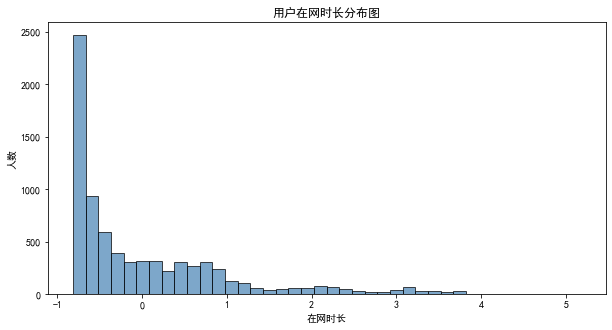

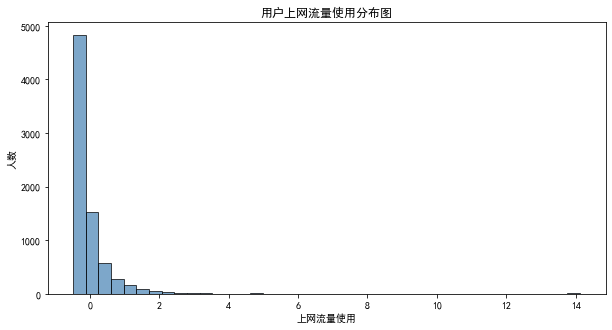

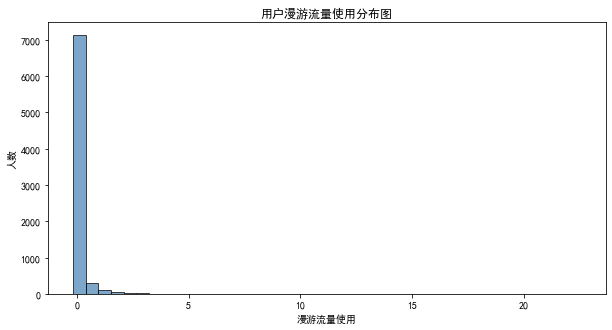

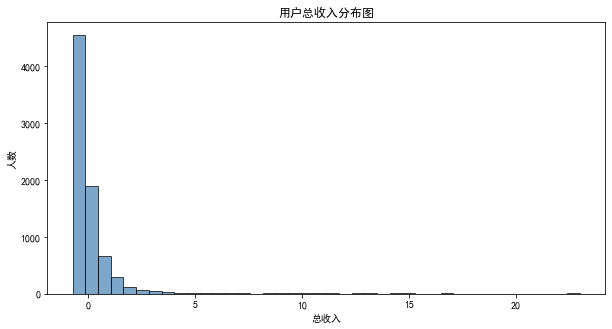

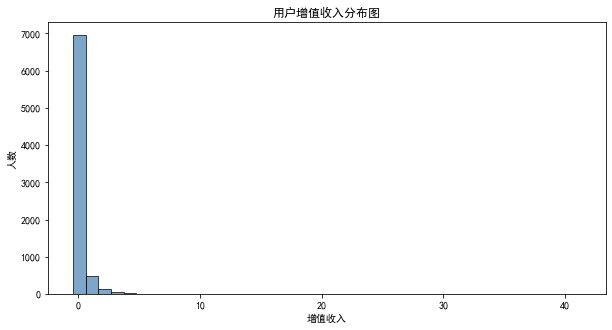

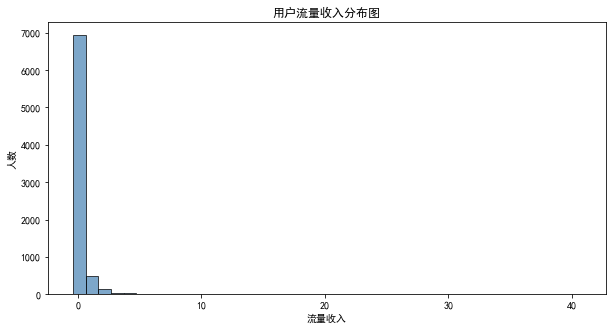

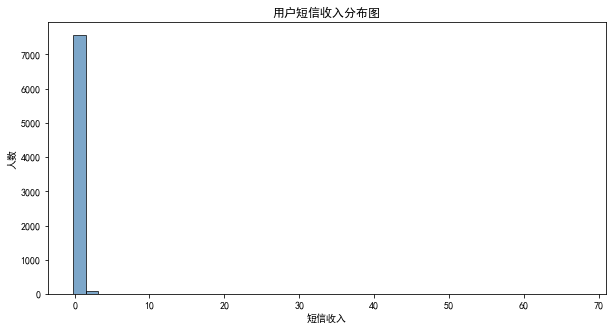

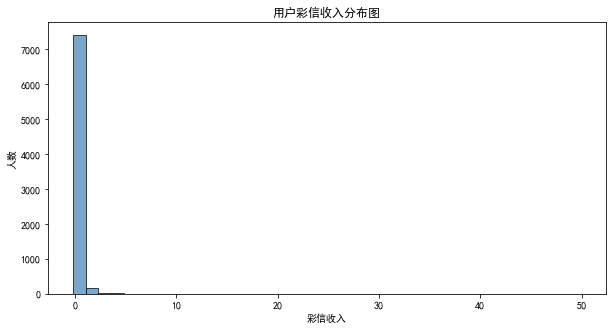

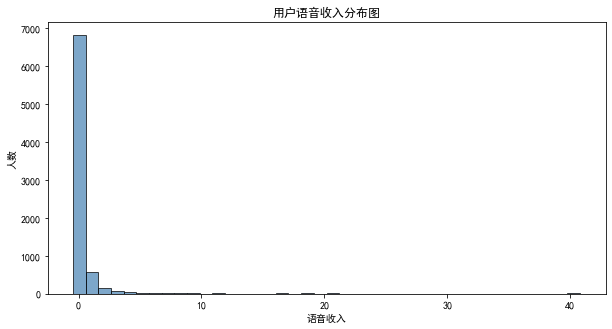

In [6]:
#查看各连续变量的分布: 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

for figure in interval:
    plt.figure(figsize=(10,5))
    plt.hist(data[figure], bins=40, facecolor="steelblue", edgecolor="black", alpha=0.7)
    plt.xlabel(figure)
    plt.ylabel("人数") 
    plt.title("用户"+figure+"分布图")
    plt.show()

### 1.1.3 定义混合型数据距离(Gower 距离) 
高尔距离使用Manhattan来计算连续数据点之间的距离，并使用Dice来计算分类数据点之间的距离

In [7]:
from scipy.sparse import issparse
import numpy as np
import pandas as pd

In [8]:
def gower_matrix(data_x, data_y=None, weight=None, cat_features=None):  
    
    # function checks
    X = data_x
    if data_y is None: Y = data_x 
    else: Y = data_y 
    if not isinstance(X, np.ndarray): 
        if not np.array_equal(X.columns, Y.columns): raise TypeError("X and Y must have same columns!")   
    else: 
         if not X.shape[1] == Y.shape[1]: raise TypeError("X and Y must have same y-dim!")  
                
    if issparse(X) or issparse(Y): raise TypeError("Sparse matrices are not supported!")        
            
    x_n_rows, x_n_cols = X.shape
    y_n_rows, y_n_cols = Y.shape 
    
    if cat_features is None:
        if not isinstance(X, np.ndarray): 
            is_number = np.vectorize(lambda x: not np.issubdtype(x, np.number))
            cat_features = is_number(X.dtypes)    
        else:
            cat_features = np.zeros(x_n_cols, dtype=bool)
            for col in range(x_n_cols):
                if not np.issubdtype(type(X[0, col]), np.number):
                    cat_features[col]=True
    else:          
        cat_features = np.array(cat_features)
    
    # print(cat_features)
    
    if not isinstance(X, np.ndarray): X = np.asarray(X)
    if not isinstance(Y, np.ndarray): Y = np.asarray(Y)
    
    Z = np.concatenate((X,Y))
    
    x_index = range(0,x_n_rows)
    y_index = range(x_n_rows,x_n_rows+y_n_rows)
    
    Z_num = Z[:,np.logical_not(cat_features)]
    
    num_cols = Z_num.shape[1]
    num_ranges = np.zeros(num_cols)
    num_max = np.zeros(num_cols)
    
    for col in range(num_cols):
        col_array = Z_num[:, col].astype(np.float32) 
        max = np.nanmax(col_array)
        min = np.nanmin(col_array)
     
        if np.isnan(max):
            max = 0.0
        if np.isnan(min):
            min = 0.0
        num_max[col] = max
        num_ranges[col] = (1 - min / max) if (max != 0) else 0.0

    # This is to normalize the numeric values between 0 and 1.
    Z_num = np.divide(Z_num ,num_max,out=np.zeros_like(Z_num), where=num_max!=0)
    Z_cat = Z[:,cat_features]
    
    if weight is None:
        weight = np.ones(Z.shape[1])
        
    #print(weight)    
    
    weight_cat=weight[cat_features]
    weight_num=weight[np.logical_not(cat_features)]   
        
    out = np.zeros((x_n_rows, y_n_rows), dtype=np.float32)
        
    weight_sum = weight.sum()
    
    X_cat = Z_cat[x_index,]
    X_num = Z_num[x_index,]
    Y_cat = Z_cat[y_index,]
    Y_num = Z_num[y_index,]
    
   # print(X_cat,X_num,Y_cat,Y_num)
    
    for i in range(x_n_rows):          
        j_start= i        
        if x_n_rows != y_n_rows:
            j_start = 0
        # call the main function
        res = gower_get(X_cat[i,:], 
                          X_num[i,:],
                          Y_cat[j_start:y_n_rows,:],
                          Y_num[j_start:y_n_rows,:],
                          weight_cat,
                          weight_num,
                          weight_sum,
                          cat_features,
                          num_ranges,
                          num_max) 
        #print(res)
        out[i,j_start:]=res
        if x_n_rows == y_n_rows: out[i:,j_start]=res
        
    return out
def gower_get(xi_cat,xi_num,xj_cat,xj_num,feature_weight_cat,
              feature_weight_num,feature_weight_sum,categorical_features,
              ranges_of_numeric,max_of_numeric ):
    
    # categorical columns
    sij_cat = np.where(xi_cat == xj_cat,np.zeros_like(xi_cat),np.ones_like(xi_cat))
    sum_cat = np.multiply(feature_weight_cat,sij_cat).sum(axis=1) 

    # numerical columns
    abs_delta=np.absolute(xi_num-xj_num)
    sij_num=np.divide(abs_delta, ranges_of_numeric, out=np.zeros_like(abs_delta), where=ranges_of_numeric!=0)

    sum_num = np.multiply(feature_weight_num,sij_num).sum(axis=1)
    sums= np.add(sum_cat,sum_num)
    sum_sij = np.divide(sums,feature_weight_sum)
    
    return sum_sij

### 1.1.5 计算SSE
聚类结果的凝聚度

In [9]:
# SSE
def calculate_sse(data_matrix):
    cluster_dict = {}
    subsse = 0
    single_sse = 0
    sse = 0
    for row in data_matrix:
        if int(row[-1]) in cluster_dict:
            cluster_dict[int(row[-1])]=np.row_stack((cluster_dict[int(row[-1])],np.mat(row[0:4])))
        else:
            cluster_dict[int(row[-1])] = np.mat(row[0:4])  #以标签为key生成词典，值为矩阵
    for cluster in cluster_dict:
        m = cluster_dict[cluster]
        cmean = np.mean(m,axis=0)  #生成一行矩阵，值为列均值
        for i in m:
            less_array = np.array([x-y for x,y in zip(i,cmean)]).flatten()  #差值数组
            #print(less_array)  
            for item in less_array:
                subsse += item*item
            single_sse += subsse
            subsse = 0
        sse += single_sse
        single_sse = 0
    #print('簇数为'+ str(len(cluster_dict)) + '时，SSE等于： '+ str(sse))
    return sse

### 1.2 用户价值分析

### 1.2.1 数据准备

In [12]:
#用户基本信息数据
value= ["是否欠费", "总收入", "在网时长","上网流量使用"]
value_target_data=target_data[value]
value_data=data[value]
display(value_target_data.head(),value_data.head())

,是否欠费,总收入,在网时长,上网流量使用
0,否,4.347047,2.772589,6.344583
1,否,4.314417,4.262680,4.679523
2,是,5.109575,3.526361,8.276708
5,否,5.430661,3.828641,7.614801
6,否,4.976734,3.828641,8.654152


,是否欠费,总收入,在网时长,上网流量使用
0,0,0.021621,0.018429,0.199311
1,0,-0.009015,1.095509,-0.551240
2,1,0.737554,0.563277,1.070247
3,0,1.039019,0.781774,0.771882
4,0,0.612830,0.781774,1.240385


In [13]:
value_D=gower_matrix(value_target_data)
print(value_D)

[[0.         0.11818364 0.35913116 ... 0.17893495 0.21818858 0.06888773]
 [0.11818364 0.         0.39838436 ... 0.14108525 0.25603828 0.10379942]
 [0.35913116 0.39838436 0.         ... 0.37680864 0.57731974 0.3522145 ]
 ...
 [0.17893495 0.14108525 0.37680864 ... 0.         0.39712352 0.17201827]
 [0.21818858 0.25603828 0.57731974 ... 0.39712352 0.         0.22510526]
 [0.06888773 0.10379942 0.3522145  ... 0.17201827 0.22510526 0.        ]]


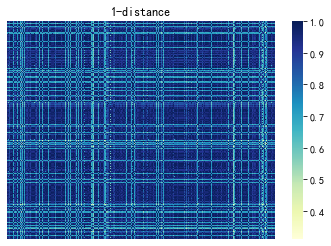

In [12]:
#相似矩阵
sns.heatmap(1-value_D[1:1000,1:1000], cmap='YlGnBu',xticklabels=False,yticklabels=False)
plt.title("1-distance")
plt.show()

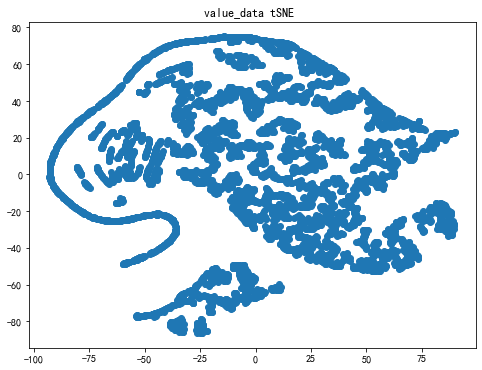

In [13]:
#tSNE
from sklearn.manifold import TSNE
import matplotlib

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

matplotlib.rcParams['axes.unicode_minus']=False

n_components=2
tsne = TSNE(n_components=n_components, init='pca', random_state=0)
tsne_data = tsne.fit_transform(value_data.iloc[:,range(3)])  # 转换后的输出

(fig, ax) = plt.subplots(figsize=(8, 6))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1])
plt.title("value_data tSNE ")
plt.show()

### 1.2.2 聚类分析方法

In [14]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.model_selection import LearningCurve

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("notebook")

from kmodes.kprototypes import KPrototypes

import scipy.cluster.hierarchy as sch #用于进行层次聚类，画层次聚类图的工具包
import scipy.spatial.distance as ssd
from scipy.cluster.vq import vq

from sklearn.cluster import DBSCAN

#### Kmeans法

In [15]:
#采用多个cluster数量进行聚类，计算SSE与轮廓系数
data_matrix = value_data.values
n_clusters=[3,4,5,6,7,8,9,10]
kmeans_sse = []
kmeans_sil = []
for num_clusters in n_clusters:
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao')
    kproto.fit_predict(data_matrix, categorical=[0])
    clusters = kproto.fit_predict(data_matrix, categorical=[0])
    kmeans_sse.append(kproto.cost_)
    kmeans_sil.append(silhouette_score(value_D,clusters,metric='euclidean')) 

array([2, 1, 2, ..., 1, 2, 2], dtype=uint16)

array([3, 1, 3, ..., 1, 3, 3], dtype=uint16)

array([4, 3, 1, ..., 3, 4, 4], dtype=uint16)

array([0, 2, 4, ..., 5, 0, 0], dtype=uint16)

array([3, 6, 4, ..., 2, 3, 3], dtype=uint16)

array([6, 1, 0, ..., 4, 6, 6], dtype=uint16)

array([8, 1, 5, ..., 6, 8, 8], dtype=uint16)

array([2, 7, 4, ..., 5, 2, 2], dtype=uint16)

Text(0.5, 0, 'n_clusters')

Text(0, 0.5, 'SSE')

Text(0.5, 1.0, 'SSE of KPrototypes')

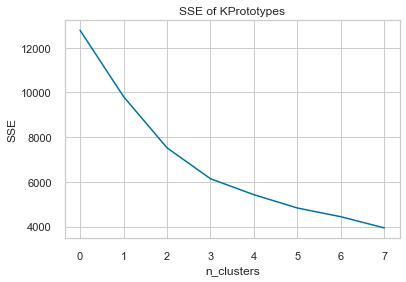

In [16]:
plt.plot(kmeans_sse)
plt.xlabel("n_clusters")
plt.ylabel("SSE") 
plt.title("SSE of KPrototypes")
plt.show()

Text(0.5, 0, 'n_clusters')

Text(0, 0.5, 'Silhouette Score')

Text(0.5, 1.0, 'Silhouette Score of KPrototypes')

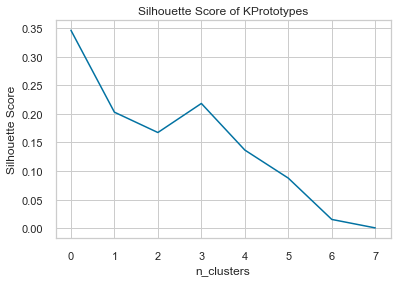

In [17]:
plt.plot(kmeans_sil)
plt.xlabel("n_clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score of KPrototypes")
plt.show()

In [15]:
#采用最合适的cluster并对数据集进行标注
#kproto = KPrototypes(n_clusters=n_clusters[2], init='Cao')
data_matrix = value_data.values
kproto = KPrototypes(n_clusters=6, init='Cao')
clusters = kproto.fit_predict(data_matrix, categorical=[0])
value_data['kmeans_cluster'] = clusters
value_data.head()

,是否欠费,总收入,在网时长,上网流量使用,kmeans_cluster
0,0,0.021621,0.018429,0.199311,5
1,0,-0.009015,1.095509,-0.551240,5
2,1,0.737554,0.563277,1.070247,3
3,0,1.039019,0.781774,0.771882,3
4,0,0.612830,0.781774,1.240385,3


#### 层次聚类法

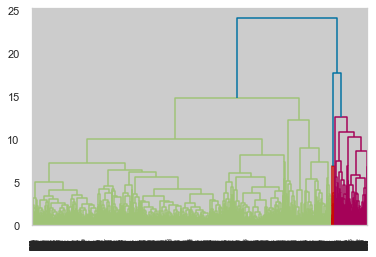

In [16]:
matplotlib.rcParams['axes.unicode_minus']=False

sch_result=sch.linkage(value_D,method='average') 
sch_figure=sch.dendrogram(sch_result)

In [28]:
data_matrix = value_data.iloc[:,range(4)].values
n_clusters=[3,4,5,6,7,8,9,10]
sch_sse = []
sch_sil = []
for num_clusters in n_clusters:
    sch_label= sch.fcluster(sch_result, t=num_clusters,criterion='maxclust')
    value_data["sch_cluster"] = sch_label
    sse=calculate_sse(value_data.iloc[:,[0,1,2,3,5]].values)
    sch_sse.append(sse)
    sch_sil.append(silhouette_score(value_D,sch_label,metric='euclidean')) 

Text(0.5, 0, 'n_clusters')

Text(0, 0.5, 'SSE')

Text(0.5, 1.0, 'SSE of 层次聚类法')

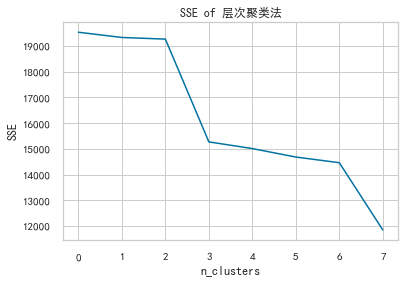

In [29]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

plt.plot(sch_sse)
plt.xlabel("n_clusters")
plt.ylabel("SSE") 
plt.title("SSE of 层次聚类法")
plt.show()

Text(0.5, 0, 'n_clusters')

Text(0, 0.5, 'Silhouette Score')

Text(0.5, 1.0, 'Silhouette Score of 层次聚类法')

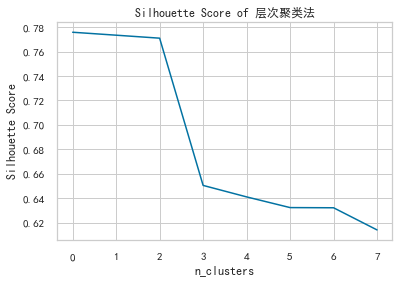

In [30]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

plt.plot(sch_sil)
plt.xlabel("n_clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score of 层次聚类法")
plt.show()

In [17]:
sch_label= sch.fcluster(sch_result, t=6,criterion='maxclust') 

value_data["sch_cluster"] = sch_label   # 详细输出每个样本对应的类别
value_data.head()

,是否欠费,总收入,在网时长,上网流量使用,kmeans_cluster,sch_cluster
0,0,0.021621,0.018429,0.199311,5,1
1,0,-0.009015,1.095509,-0.551240,5,1
2,1,0.737554,0.563277,1.070247,3,5
3,0,1.039019,0.781774,0.771882,3,1
4,0,0.612830,0.781774,1.240385,3,1


#### DBSCAN法

In [33]:
eps_list = np.arange(0.5,2.1,step=0.1)
min_samples_list=[5,10,15,20]

dbscan_sse = []
dbscan_sil = []
params = []

for eps in eps_list:
    for min_samples in min_samples_list:
        params.append([round(eps, 2),min_samples]) 
        

for i in range(64):
    eps, min_samples = params[i]
    dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_model.fit(value_data.iloc[:,range(4)])
    dbscan_label = dbscan_model.labels_
    dbscan_unique = np.unique(dbscan_label)
    
    n_clusters = len([i for i in set(dbscan_model.labels_) if i != -1])
    outliners = np.sum(np.where(dbscan_model.labels_ == -1, 1,0))
    print('parameter:',eps, min_samples)
    print('clusters: ',n_clusters,'outliers: ',outliners,'\n')
    
    value_data['dbscan_cluster'] = dbscan_label
    sse=calculate_sse(value_data.iloc[:,[0,1,2,3,6]].values)
    dbscan_sse.append(sse)
    dbscan_sil.append(silhouette_score(value_D,dbscan_label,metric='euclidean')) 

DBSCAN()

parameter: 0.5 5
clusters:  5 outliers:  196 



DBSCAN(min_samples=10)

parameter: 0.5 10
clusters:  2 outliers:  286 



DBSCAN(min_samples=15)

parameter: 0.5 15
clusters:  2 outliers:  334 



DBSCAN(min_samples=20)

parameter: 0.5 20
clusters:  3 outliers:  391 



DBSCAN(eps=0.6)

parameter: 0.6 5
clusters:  5 outliers:  142 



DBSCAN(eps=0.6, min_samples=10)

parameter: 0.6 10
clusters:  2 outliers:  211 



DBSCAN(eps=0.6, min_samples=15)

parameter: 0.6 15
clusters:  2 outliers:  255 



DBSCAN(eps=0.6, min_samples=20)

parameter: 0.6 20
clusters:  2 outliers:  282 



DBSCAN(eps=0.7)

parameter: 0.7 5
clusters:  6 outliers:  121 



DBSCAN(eps=0.7, min_samples=10)

parameter: 0.7 10
clusters:  3 outliers:  161 



DBSCAN(eps=0.7, min_samples=15)

parameter: 0.7 15
clusters:  2 outliers:  198 



DBSCAN(eps=0.7, min_samples=20)

parameter: 0.7 20
clusters:  2 outliers:  228 



DBSCAN(eps=0.8)

parameter: 0.8 5
clusters:  4 outliers:  100 



DBSCAN(eps=0.8, min_samples=10)

parameter: 0.8 10
clusters:  3 outliers:  137 



DBSCAN(eps=0.8, min_samples=15)

parameter: 0.8 15
clusters:  2 outliers:  156 



DBSCAN(eps=0.8, min_samples=20)

parameter: 0.8 20
clusters:  2 outliers:  179 



DBSCAN(eps=0.9)

parameter: 0.9 5
clusters:  3 outliers:  89 



DBSCAN(eps=0.9, min_samples=10)

parameter: 0.9 10
clusters:  3 outliers:  118 



DBSCAN(eps=0.9, min_samples=15)

parameter: 0.9 15
clusters:  2 outliers:  143 



DBSCAN(eps=0.9, min_samples=20)

parameter: 0.9 20
clusters:  2 outliers:  151 



DBSCAN(eps=1.0)

parameter: 1.0 5
clusters:  4 outliers:  70 



DBSCAN(eps=1.0, min_samples=10)

parameter: 1.0 10
clusters:  3 outliers:  97 



DBSCAN(eps=1.0, min_samples=15)

parameter: 1.0 15
clusters:  2 outliers:  129 



DBSCAN(eps=1.0, min_samples=20)

parameter: 1.0 20
clusters:  2 outliers:  136 



DBSCAN(eps=1.1)

parameter: 1.1 5
clusters:  3 outliers:  46 



DBSCAN(eps=1.1, min_samples=10)

parameter: 1.1 10
clusters:  2 outliers:  65 



DBSCAN(eps=1.1, min_samples=15)

parameter: 1.1 15
clusters:  2 outliers:  95 



DBSCAN(eps=1.1, min_samples=20)

parameter: 1.1 20
clusters:  1 outliers:  118 



DBSCAN(eps=1.2)

parameter: 1.2 5
clusters:  3 outliers:  41 



DBSCAN(eps=1.2, min_samples=10)

parameter: 1.2 10
clusters:  2 outliers:  61 



DBSCAN(eps=1.2, min_samples=15)

parameter: 1.2 15
clusters:  1 outliers:  85 



DBSCAN(eps=1.2, min_samples=20)

parameter: 1.2 20
clusters:  1 outliers:  93 



DBSCAN(eps=1.3)

parameter: 1.3 5
clusters:  4 outliers:  32 



DBSCAN(eps=1.3, min_samples=10)

parameter: 1.3 10
clusters:  2 outliers:  56 



DBSCAN(eps=1.3, min_samples=15)

parameter: 1.3 15
clusters:  1 outliers:  77 



DBSCAN(eps=1.3, min_samples=20)

parameter: 1.3 20
clusters:  1 outliers:  85 



DBSCAN(eps=1.4)

parameter: 1.4 5
clusters:  4 outliers:  31 



DBSCAN(eps=1.4, min_samples=10)

parameter: 1.4 10
clusters:  2 outliers:  51 



DBSCAN(eps=1.4, min_samples=15)

parameter: 1.4 15
clusters:  1 outliers:  74 



DBSCAN(eps=1.4, min_samples=20)

parameter: 1.4 20
clusters:  1 outliers:  78 



DBSCAN(eps=1.5)

parameter: 1.5 5
clusters:  4 outliers:  29 



DBSCAN(eps=1.5, min_samples=10)

parameter: 1.5 10
clusters:  2 outliers:  47 



DBSCAN(eps=1.5, min_samples=15)

parameter: 1.5 15
clusters:  1 outliers:  67 



DBSCAN(eps=1.5, min_samples=20)

parameter: 1.5 20
clusters:  1 outliers:  74 



DBSCAN(eps=1.6)

parameter: 1.6 5
clusters:  4 outliers:  26 



DBSCAN(eps=1.6, min_samples=10)

parameter: 1.6 10
clusters:  2 outliers:  46 



DBSCAN(eps=1.6, min_samples=15)

parameter: 1.6 15
clusters:  1 outliers:  59 



DBSCAN(eps=1.6, min_samples=20)

parameter: 1.6 20
clusters:  1 outliers:  68 



DBSCAN(eps=1.7)

parameter: 1.7 5
clusters:  3 outliers:  20 



DBSCAN(eps=1.7, min_samples=10)

parameter: 1.7 10
clusters:  2 outliers:  41 



DBSCAN(eps=1.7, min_samples=15)

parameter: 1.7 15
clusters:  1 outliers:  55 



DBSCAN(eps=1.7, min_samples=20)

parameter: 1.7 20
clusters:  1 outliers:  61 



DBSCAN(eps=1.8)

parameter: 1.8 5
clusters:  2 outliers:  15 



DBSCAN(eps=1.8, min_samples=10)

parameter: 1.8 10
clusters:  2 outliers:  40 



DBSCAN(eps=1.8, min_samples=15)

parameter: 1.8 15
clusters:  1 outliers:  55 



DBSCAN(eps=1.8, min_samples=20)

parameter: 1.8 20
clusters:  1 outliers:  55 



DBSCAN(eps=1.9)

parameter: 1.9 5
clusters:  2 outliers:  15 



DBSCAN(eps=1.9, min_samples=10)

parameter: 1.9 10
clusters:  2 outliers:  35 



DBSCAN(eps=1.9, min_samples=15)

parameter: 1.9 15
clusters:  1 outliers:  51 



DBSCAN(eps=1.9, min_samples=20)

parameter: 1.9 20
clusters:  1 outliers:  54 



DBSCAN(eps=2.0)

parameter: 2.0 5
clusters:  2 outliers:  15 



DBSCAN(eps=2.0, min_samples=10)

parameter: 2.0 10
clusters:  2 outliers:  32 



DBSCAN(eps=2.0, min_samples=15)

parameter: 2.0 15
clusters:  1 outliers:  48 



DBSCAN(eps=2.0, min_samples=20)

parameter: 2.0 20
clusters:  1 outliers:  53 



Text(0.5, 0, 'parameters')

Text(0, 0.5, 'SSE')

Text(0.5, 1.0, 'SSE of DBSCAN')

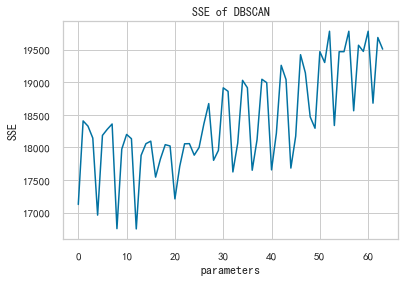

In [34]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

plt.plot(dbscan_sse)
plt.xlabel("parameters")
plt.ylabel("SSE") 
plt.title("SSE of DBSCAN")
plt.show()

Text(0.5, 0, 'parameters')

Text(0, 0.5, 'Silhouette Score')

Text(0.5, 1.0, 'Silhouette Score of DBSCAN')

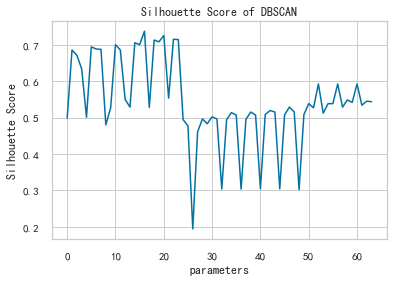

In [35]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

plt.plot(dbscan_sil)
plt.xlabel("parameters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score of DBSCAN")
plt.show()

In [46]:
params[20]
dbscan_model = DBSCAN(eps=1.0, min_samples=5)
dbscan_model.fit(value_data.iloc[:,range(4)])
dbscan_label = dbscan_model.labels_
value_data['dbscan_cluster'] = dbscan_label

value_data.head()

[1.0, 5]

DBSCAN(eps=1.0)

,是否欠费,总收入,在网时长,上网流量使用,kmeans_cluster,sch_cluster,dbscan_cluster
0,0,-0.283220,-0.460269,-0.285434,2,1,0
1,0,-0.297920,0.940362,-0.447181,0,1,0
2,1,0.240469,-0.001880,0.892357,3,4,1
3,0,0.612119,0.303712,0.225572,5,1,0
4,0,0.118364,0.303712,1.523909,5,1,0


In [18]:
dbscan_model = DBSCAN(eps=1.0, min_samples=5)
dbscan_model.fit(value_data.iloc[:,range(4)])
dbscan_label = dbscan_model.labels_
value_data['dbscan_cluster'] = dbscan_label

value_data.head()

DBSCAN(eps=1.0)

,是否欠费,总收入,在网时长,上网流量使用,kmeans_cluster,sch_cluster,dbscan_cluster
0,0,0.021621,0.018429,0.199311,5,1,0
1,0,-0.009015,1.095509,-0.551240,5,1,0
2,1,0.737554,0.563277,1.070247,3,5,1
3,0,1.039019,0.781774,0.771882,3,1,0
4,0,0.612830,0.781774,1.240385,3,1,0


### 1.2.3 聚类结果比较

In [42]:
#各数据比较
print("SSE: Kprototypes:",kmeans_sse[3],"层次聚类法",sch_sse[3],"DBSCAN",dbscan_sse[20])
print("轮廓系数: Kprototypes:",kmeans_sil[3],"层次聚类法",sch_sil[3],"DBSCAN",dbscan_sil[20])

SSE: Kprototypes: 6137.294560215848 层次聚类法 15271.192058774226 DBSCAN 17209.076687873723
轮廓系数: Kprototypes: 0.21822657 层次聚类法 0.6504356 DBSCAN 0.72546744


Text(0.5, 1.0, 'kmeans-tSNE ')

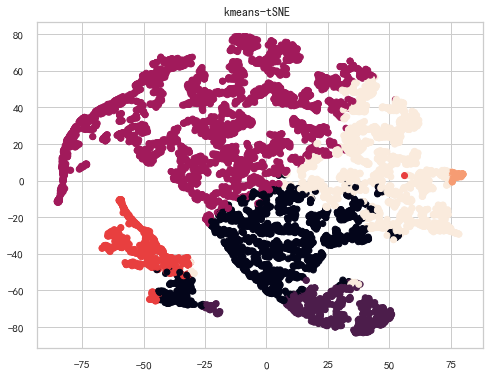

Text(0.5, 1.0, '层次聚类-tSNE ')

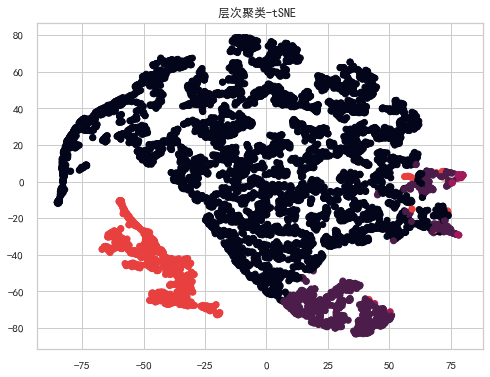

Text(0.5, 1.0, 'DBSCAN-tSNE ')

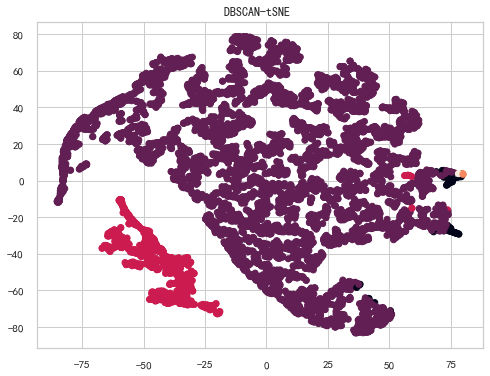

In [49]:
#tSNE
from sklearn.manifold import TSNE
import matplotlib

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

matplotlib.rcParams['axes.unicode_minus']=False

n_components=2
tsne = TSNE(n_components=n_components, init='pca', random_state=0)
tsne_data = tsne.fit_transform(value_data.iloc[:,range(4)])  # 转换后的输出

(fig, ax) = plt.subplots(figsize=(8, 6))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1],c=value_data.iloc[:,4])
plt.title("kmeans-tSNE ")
plt.show()

(fig, ax) = plt.subplots(figsize=(8, 6))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1],c=value_data.iloc[:,5])
plt.title("层次聚类-tSNE ")
plt.show()

(fig, ax) = plt.subplots(figsize=(8, 6))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1],c=value_data.iloc[:,6])
plt.title("DBSCAN-tSNE ")
plt.show()

### 1.2.4 聚类结果含义

In [ ]:
#雷达图比较
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, polar=True) #polar=True 画圆形
feature = ['是否欠费','总收入','在网时长','上网流量使用']
center_num = value_data.iloc[:,[0,1,2,3,4]].values  #<class 'numpy.ndarray'>
N = len(feature)

for i, v in enumerate(center_num):
    # 设置雷达图的角度，用于平分切开一个圆面
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    # 为了使雷达图一圈封闭起来，需要下面的步骤
    center = np.concatenate((v[:-1], [v[0]]))
    angles = np.concatenate((angles, [angles[0]]))
    # 绘制折线图
    ax.plot(angles, center, 'o-', linewidth=2, label="NO.%d = %d" % (i + 1, v[-1]))
    # 填充颜色
    ax.fill(angles, center, alpha=0.25)
    # 添加每个特征的标签
    ax.set_thetagrids(angles[:-1] * 180 / np.pi, feature, fontsize=12)
    # 设置雷达图的范围
    #ax.set_ylim(min - 0.1, max + 0.1)
    # 添加标题
    plt.title('Kmeans法 通信用户聚类', fontsize=20)
    # 添加网格线
    ax.grid(True)
    # 设置图例
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), ncol=1, fancybox=True, shadow=True)

# 显示图形
plt.show()

In [ ]:
#雷达图比较
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, polar=True) #polar=True 画圆形
feature = ['是否欠费','总收入','在网时长','上网流量使用']
center_num = value_data.iloc[:,[0,1,2,3,5]].values  #<class 'numpy.ndarray'>
N = len(feature)

for i, v in enumerate(center_num):
    # 设置雷达图的角度，用于平分切开一个圆面
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    # 为了使雷达图一圈封闭起来，需要下面的步骤
    center = np.concatenate((v[:-1], [v[0]]))
    angles = np.concatenate((angles, [angles[0]]))
    # 绘制折线图
    ax.plot(angles, center, 'o-', linewidth=2, label="NO.%d = %d" % (i + 1, v[-1]))
    # 填充颜色
    ax.fill(angles, center, alpha=0.25)
    # 添加每个特征的标签
    ax.set_thetagrids(angles[:-1] * 180 / np.pi, feature, fontsize=12)
    # 设置雷达图的范围
    #ax.set_ylim(min - 0.1, max + 0.1)
    # 添加标题
    plt.title('层次聚类法 通信用户聚类', fontsize=20)
    # 添加网格线
    ax.grid(True)
    # 设置图例
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), ncol=1, fancybox=True, shadow=True)

# 显示图形
plt.show()

In [ ]:
#雷达图比较
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, polar=True) #polar=True 画圆形
feature = ['是否欠费','总收入','在网时长','上网流量使用']
center_num = value_data.iloc[:,[0,1,2,3,6]].values  #<class 'numpy.ndarray'>
N = len(feature)

for i, v in enumerate(center_num):
    # 设置雷达图的角度，用于平分切开一个圆面
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    # 为了使雷达图一圈封闭起来，需要下面的步骤
    center = np.concatenate((v[:-1], [v[0]]))
    angles = np.concatenate((angles, [angles[0]]))
    # 绘制折线图
    ax.plot(angles, center, 'o-', linewidth=2, label="NO.%d = %d" % (i + 1, v[-1]))
    # 填充颜色
    ax.fill(angles, center, alpha=0.25)
    # 添加每个特征的标签
    ax.set_thetagrids(angles[:-1] * 180 / np.pi, feature, fontsize=12)
    # 设置雷达图的范围
    #ax.set_ylim(min - 0.1, max + 0.1)
    # 添加标题
    plt.title('DBSCAN法 通信用户聚类', fontsize=20)
    # 添加网格线
    ax.grid(True)
    # 设置图例
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), ncol=1, fancybox=True, shadow=True)

# 显示图形
plt.show()

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

(<a list of 8 Line2D ticklines objects>,
 [Text(0.0, 0, '是否欠费'),
  Text(1.5707963267948966, 0, '总收入'),
  Text(3.141592653589793, 0, '在网时长'),
  Text(4.71238898038469, 0, '上网流量使用')])

Text(0.5, 1.0, 'DBSCAN法 通信用户聚类')

<AxesSubplot:xlabel='kmeans_cluster', ylabel='value'>

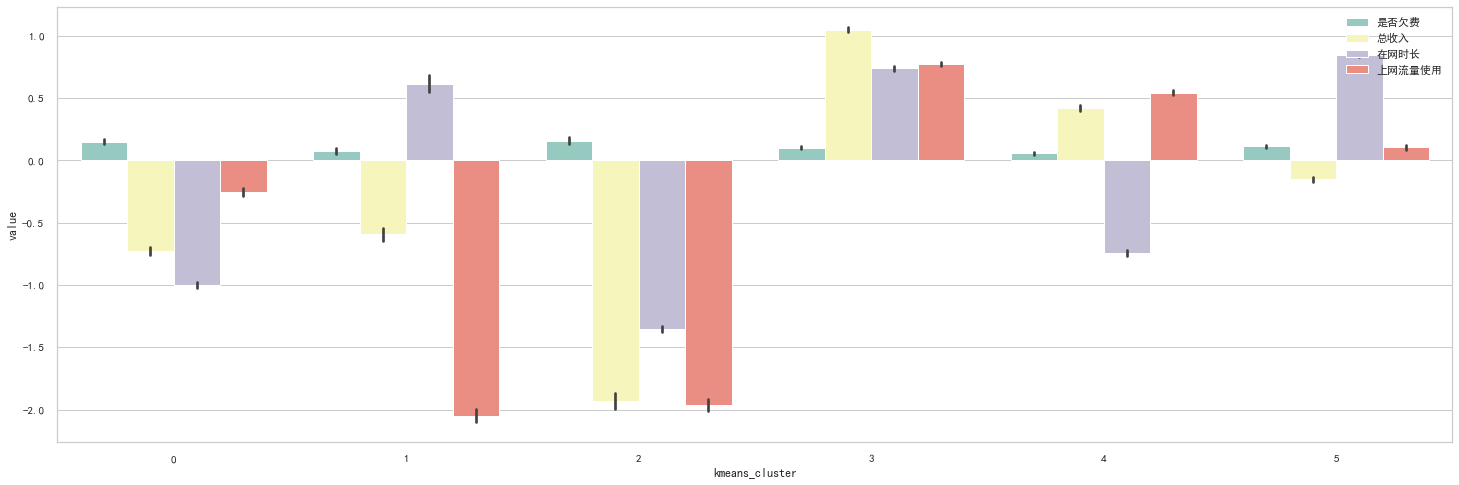

In [22]:
#直方图
import matplotlib
matplotlib.rc('font', family='SimHei')

hist_data = value_data.iloc[:,[0,1,2,3,4]].melt(id_vars='kmeans_cluster')
fig, ax = plt.subplots(figsize=(25, 8))
sns.barplot(x='kmeans_cluster', y='value', hue='variable', data=hist_data, palette='Set3')
plt.legend(loc='upper right')
plt.show()

<Figure size 640x320 with 0 Axes>

<AxesSubplot:xlabel='是否欠费', ylabel='Density'>

<AxesSubplot:xlabel='是否欠费', ylabel='Density'>

<AxesSubplot:xlabel='是否欠费', ylabel='Density'>

<AxesSubplot:xlabel='是否欠费', ylabel='Density'>

<AxesSubplot:xlabel='是否欠费', ylabel='Density'>

<AxesSubplot:xlabel='是否欠费', ylabel='Density'>

Text(0.5, 1.0, '欠费密度图')

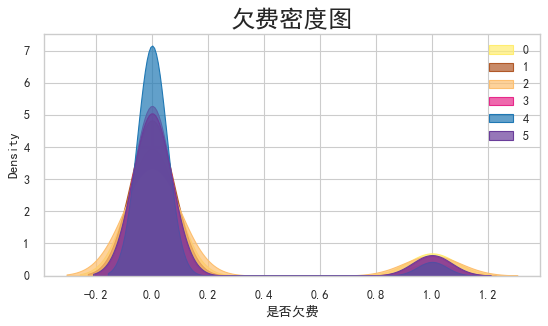

<Figure size 640x320 with 0 Axes>

<AxesSubplot:xlabel='总收入', ylabel='Density'>

<AxesSubplot:xlabel='总收入', ylabel='Density'>

<AxesSubplot:xlabel='总收入', ylabel='Density'>

<AxesSubplot:xlabel='总收入', ylabel='Density'>

<AxesSubplot:xlabel='总收入', ylabel='Density'>

<AxesSubplot:xlabel='总收入', ylabel='Density'>

Text(0.5, 1.0, '总收入密度图')

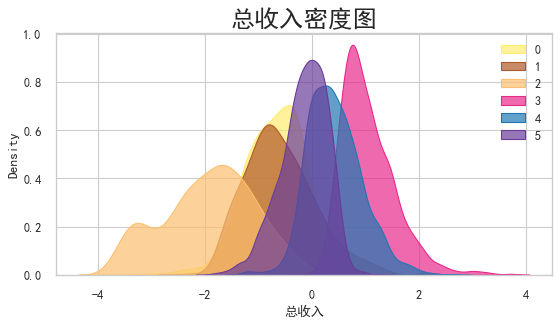

<Figure size 640x320 with 0 Axes>

<AxesSubplot:xlabel='在网时长', ylabel='Density'>

<AxesSubplot:xlabel='在网时长', ylabel='Density'>

<AxesSubplot:xlabel='在网时长', ylabel='Density'>

<AxesSubplot:xlabel='在网时长', ylabel='Density'>

<AxesSubplot:xlabel='在网时长', ylabel='Density'>

<AxesSubplot:xlabel='在网时长', ylabel='Density'>

Text(0.5, 1.0, '在网时长密度图')

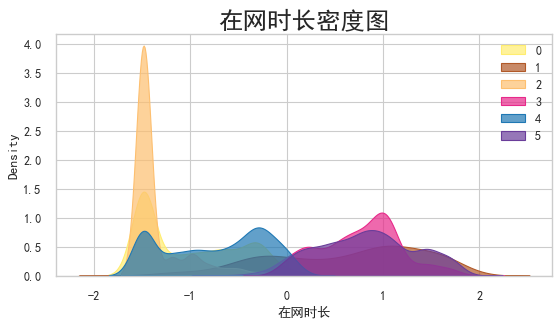

<Figure size 640x320 with 0 Axes>

<AxesSubplot:xlabel='上网流量使用', ylabel='Density'>

<AxesSubplot:xlabel='上网流量使用', ylabel='Density'>

<AxesSubplot:xlabel='上网流量使用', ylabel='Density'>

<AxesSubplot:xlabel='上网流量使用', ylabel='Density'>

<AxesSubplot:xlabel='上网流量使用', ylabel='Density'>

<AxesSubplot:xlabel='上网流量使用', ylabel='Density'>

Text(0.5, 1.0, '上网流量使用密度图')

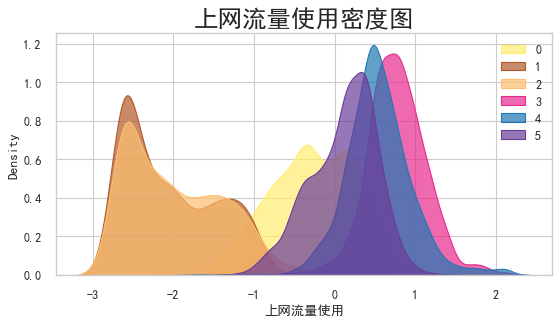

In [19]:
# 密度图
# Draw Plot
plt.figure(figsize=(8,4), dpi= 80)
sns.kdeplot(value_data.loc[value_data['kmeans_cluster'] == 0, "是否欠费"], shade=True, color="#FFED6F", label="0", alpha=.7)
sns.kdeplot(value_data.loc[value_data['kmeans_cluster'] == 1, "是否欠费"], shade=True, color="#B15928", label="1", alpha=.7)
sns.kdeplot(value_data.loc[value_data['kmeans_cluster'] == 2, "是否欠费"], shade=True, color="#FDBF6F", label="2", alpha=.7)
sns.kdeplot(value_data.loc[value_data['kmeans_cluster'] == 3, "是否欠费"], shade=True, color="#E7298A", label="3", alpha=.7)
sns.kdeplot(value_data.loc[value_data['kmeans_cluster'] == 4, "是否欠费"], shade=True, color="#1F78B4", label="4", alpha=.7)
sns.kdeplot(value_data.loc[value_data['kmeans_cluster'] == 5, "是否欠费"], shade=True, color="#6A3D9A", label="5", alpha=.7)
# 
# Decoration
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.title('欠费密度图', fontsize=22)
plt.legend()
plt.show()

# 密度图
# Draw Plot
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

plt.figure(figsize=(8,4), dpi= 80)
sns.kdeplot(value_data.loc[value_data['kmeans_cluster'] == 0, "总收入"], shade=True, color="#FFED6F", label="0", alpha=.7)
sns.kdeplot(value_data.loc[value_data['kmeans_cluster'] == 1, "总收入"], shade=True, color="#B15928", label="1", alpha=.7)
sns.kdeplot(value_data.loc[value_data['kmeans_cluster'] == 2, "总收入"], shade=True, color="#FDBF6F", label="2", alpha=.7)
sns.kdeplot(value_data.loc[value_data['kmeans_cluster'] == 3, "总收入"], shade=True, color="#E7298A", label="3", alpha=.7)
sns.kdeplot(value_data.loc[value_data['kmeans_cluster'] == 4, "总收入"], shade=True, color="#1F78B4", label="4", alpha=.7)
sns.kdeplot(value_data.loc[value_data['kmeans_cluster'] == 5, "总收入"], shade=True, color="#6A3D9A", label="5", alpha=.7)

# Decoration
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.title('总收入密度图', fontsize=22)
plt.legend()
plt.show()

# 密度图
# Draw Plot
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

plt.figure(figsize=(8,4), dpi= 80)
sns.kdeplot(value_data.loc[value_data['kmeans_cluster'] == 0, "在网时长"], shade=True, color="#FFED6F", label="0", alpha=.7)
sns.kdeplot(value_data.loc[value_data['kmeans_cluster'] == 1, "在网时长"], shade=True, color="#B15928", label="1", alpha=.7)
sns.kdeplot(value_data.loc[value_data['kmeans_cluster'] == 2, "在网时长"], shade=True, color="#FDBF6F", label="2", alpha=.7)
sns.kdeplot(value_data.loc[value_data['kmeans_cluster'] == 3, "在网时长"], shade=True, color="#E7298A", label="3", alpha=.7)
sns.kdeplot(value_data.loc[value_data['kmeans_cluster'] == 4, "在网时长"], shade=True, color="#1F78B4", label="4", alpha=.7)
sns.kdeplot(value_data.loc[value_data['kmeans_cluster'] == 5, "在网时长"], shade=True, color="#6A3D9A", label="5", alpha=.7)

# Decoration
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.title('在网时长密度图', fontsize=22)
plt.legend()
plt.show()

# 密度图
# Draw Plot
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

plt.figure(figsize=(8,4), dpi= 80)
sns.kdeplot(value_data.loc[value_data['kmeans_cluster'] == 0, "上网流量使用"], shade=True, color="#FFED6F", label="0", alpha=.7)
sns.kdeplot(value_data.loc[value_data['kmeans_cluster'] == 1, "上网流量使用"], shade=True, color="#B15928", label="1", alpha=.7)
sns.kdeplot(value_data.loc[value_data['kmeans_cluster'] == 2, "上网流量使用"], shade=True, color="#FDBF6F", label="2", alpha=.7)
sns.kdeplot(value_data.loc[value_data['kmeans_cluster'] == 3, "上网流量使用"], shade=True, color="#E7298A", label="3", alpha=.7)
sns.kdeplot(value_data.loc[value_data['kmeans_cluster'] == 4, "上网流量使用"], shade=True, color="#1F78B4", label="4", alpha=.7)
sns.kdeplot(value_data.loc[value_data['kmeans_cluster'] == 5, "上网流量使用"], shade=True, color="#6A3D9A", label="5", alpha=.7)

# Decoration
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.title('上网流量使用密度图', fontsize=22)
plt.legend()
plt.show()